In [1]:
import numpy as np
import pandas as pd

In [2]:
df=pd.read_csv(r'E:\54339_104884_bundle_archive/HAM10000_metadata.csv')
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [3]:
df['dx'].unique()

array(['bkl', 'nv', 'df', 'mel', 'vasc', 'bcc', 'akiec'], dtype=object)

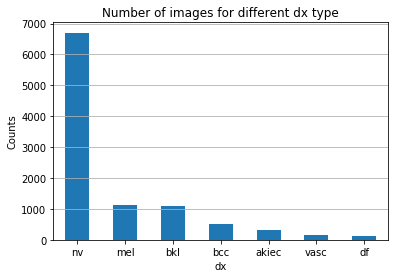

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
df['dx'].value_counts().plot.bar(rot=0)
plt.title('Number of images for different dx type')
plt.xlabel('dx')
plt.ylabel('Counts')
plt.grid(axis='y')

In [ ]:
# Creating 'num_images' to record the number of images belonging to the same 'lesion_id'
# Creating 'dx_id' convert the 'dx' to integer label
# Creating 'image_path' to store the path to access the image
# Creating 'images' to store the resized image as arrays

from os.path import isfile
from PIL import Image as pil_image
df['num_images'] = df.groupby('lesion_id')["image_id"].transform("count")

classes = df['dx'].unique()
labeldict = {}
for num, name in enumerate(classes):
    labeldict[name] = num
df['dx_id'] = df['dx'].map(lambda x: labeldict[x])


def expand_path(p):
    if isfile(r'E:\54339_104884_bundle_archive\HAM10000_images_part_1/' + p + '.jpg'): return r'E:\54339_104884_bundle_archive\HAM10000_images_part_1/' + p + '.jpg'
    return p 
df['image_path'] = df['image_id']
df['image_path'] = df['image_path'].apply(expand_path)


df['images'] = df['image_path'].map(lambda x: np.asarray(pil_image.open(x).resize((150,112))))
df.head()

In [ ]:
def plot_images(imgs, labels, cols=4):
    # Setting figure to 13 inches x 8 inches
    figure = plt.figure(figsize=(10, 7))

    rows = len(imgs) // cols + 1

    for i in range(len(imgs)):
        img = plt.imread(expand_path(imgs[i]))
        subplot = figure.add_subplot(rows, cols, i + 1)
        subplot.axis('Off')
        if labels:
            subplot.set_title(labels[i], fontsize=16)
        plt.imshow(img, cmap='gray')        

images = df[df['lesion_id'] == 'HAM_0003033'].image_id

plot_images(list(images),list(images))

In [ ]:
# Images belonging to the seven different types
imgdict = {'akiec':list(df[df['dx']=='akiec']['image_id'])[0:24:6],'bcc':list(df[df['dx']=='bcc']['image_id'])[0:24:6],\
        'bkl':list(df[df['dx']=='bkl']['image_id'])[0:24:6],'df':list(df[df['dx']=='df']['image_id'])[0:24:6],\
        'mel':list(df[df['dx']=='mel']['image_id'])[0:24:6],'nv':list(df[df['dx']=='nv']['image_id'])[0:24:6],\
        'vasc':list(df[df['dx']=='vasc']['image_id'])[0:24:6]}

for i in np.arange(7):
    cancertype = list(imgdict.keys())[i]
    cancertypetolist = [cancertype,cancertype,cancertype,cancertype]
    plot_images(list(imgdict.values())[i],cancertypetolist)

In [ ]:
# Splitting the dataframe and creating train, test and validation images and labels
from sklearn.model_selection import train_test_split

# selecting the testset and validationset from the lesion_id with only one corresponding image_id. 
# as these images have no similar sibling images

df_single = df[df['num_images'] == 1]
trainset1, testset = train_test_split(df_single, test_size=0.2,random_state = 700)
trainset2, validationset = train_test_split(trainset1, test_size=0.2,random_state = 234)
trainset3 = df[df['num_images'] != 1]
frames = [trainset2, trainset3]
trainset = pd.concat(frames)

def prepareimages(images):
    # images is a list of images
    images = np.asarray(images).astype(np.float64)
    images = images[:, :, :, ::-1]
    m0 = np.mean(images[:, :, :, 0])
    m1 = np.mean(images[:, :, :, 1])
    m2 = np.mean(images[:, :, :, 2])
    images[:, :, :, 0] -= m0
    images[:, :, :, 1] -= m1
    images[:, :, :, 2] -= m2
    return images
trainimages = prepareimages(list(trainset['images']))
testimages = prepareimages(list(testset['images']))
validationimages = prepareimages(list(validationset['images']))
trainlabels = np.asarray(trainset['dx_id'])
testlabels = np.asarray(testset['dx_id'])
validationlabels = np.asarray(validationset['dx_id'])
print(np.shape(trainimages))
print(np.shape(testimages))
print(np.shape(validationimages))

In [14]:
# Data Augmentation
# It includes rotation, zoom, shift in two directions
from keras.preprocessing.image import ImageDataGenerator

trainimages = trainimages.reshape(trainimages.shape[0], *(112, 150, 3))

data_gen = ImageDataGenerator(
        rotation_range=90,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally
        height_shift_range=0.1,  # randomly shift images vertically
        horizontal_flip=True, 
        vertical_flip=True)

data_gen.fit(trainimages)

Using TensorFlow backend.


In [15]:
#Building CNN model - VGG16
from tensorflow.python.keras.applications import VGG16
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Dropout
from keras import regularizers

input_shape = (112, 150, 3)

num_labels = 7

base_model = VGG16(include_top=False, input_shape=(112, 150, 3),pooling = 'avg', weights = 'imagenet')

model = Sequential()
model.add(base_model)
model.add(Dropout(0.5))
model.add(Dense(128, activation="relu",kernel_regularizer=regularizers.l2(0.02)))
model.add(Dropout(0.5))
model.add(Dense(num_labels, activation = 'softmax',kernel_regularizer=regularizers.l2(0.02)))

for layer in base_model.layers:
    layer.trainable = False

model.summary()

58892288/58889256 [==============================] - 675s 11us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 512)               14714688  
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               65664     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 903       
Total params: 14,781,255
Trainable params: 66,567
Non-trainable params: 14,714,688
_________________________________________________________________


In [18]:
from tensorflow.keras.optimizers import Adam
optimizer = Adam (lr=0.0005, beta_1=0.9, beta_2=0.999, epsilon=None, decay=5e-7, amsgrad=False)
model.compile(optimizer = optimizer , loss = "sparse_categorical_crossentropy", metrics=["accuracy"])

In [20]:
import keras
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint
class CustomModelCheckPoint(keras.callbacks.Callback):
    def __init__(self,**kargs):
        super(CustomModelCheckPoint,self).__init__(**kargs)
        self.epoch_accuracy = {} # loss at given epoch
        self.epoch_loss = {} # accuracy at given epoch
        def on_epoch_begin(self,epoch, logs={}):
            # Things done on beginning of epoch. 
            return

        def on_epoch_end(self, epoch, logs={}):
            # things done on end of the epoch
            self.epoch_accuracy[epoch] = logs.get("acc")
            self.epoch_loss[epoch] = logs.get("loss")
            self.model.save_weights("name-of-model-%d.h5" %epoch)
            
checkpoilnt = CustomModelCheckPoint()
cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = 3)
cb_checkpointer = ModelCheckpoint(filepath = 'best.hdf5', monitor = 'val_loss', save_best_only = True, mode = 'auto')
epochs = 5
batch_size = 30
trainhistory = model.fit_generator(data_gen.flow(trainimages,trainlabels, batch_size=batch_size),
                              epochs = epochs, validation_data = (validationimages,validationlabels),
                              verbose = 1, steps_per_epoch=trainimages.shape[0] // batch_size,
                                       callbacks=[cb_checkpointer, cb_early_stopper])


Epoch 1/5
267/267 [==============================] - 4850s 18s/step - loss: 5.9897 - accuracy: 0.5501 - val_loss: 3.2362 - val_accuracy: 0.8188
Epoch 2/5
267/267 [==============================] - 4661s 17s/step - loss: 3.5578 - accuracy: 0.5828 - val_loss: 2.6281 - val_accuracy: 0.8131
Epoch 3/5
267/267 [==============================] - 4649s 17s/step - loss: 2.7485 - accuracy: 0.6197 - val_loss: 2.0915 - val_accuracy: 0.8120
Epoch 4/5
267/267 [==============================] - 4633s 17s/step - loss: 2.2346 - accuracy: 0.6382 - val_loss: 1.6930 - val_accuracy: 0.8131
Epoch 5/5
267/267 [==============================] - 4634s 17s/step - loss: 1.9015 - accuracy: 0.6416 - val_loss: 1.3679 - val_accuracy: 0.8131


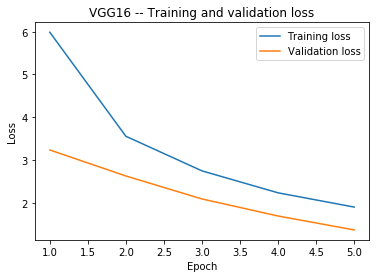

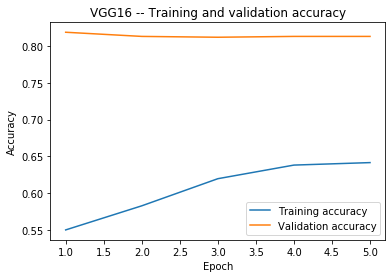

In [26]:
acc = trainhistory.history['accuracy']
val_acc = trainhistory.history['val_accuracy']
loss = trainhistory.history['loss']
val_loss = trainhistory.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, '', label='Training loss')
plt.plot(epochs, val_loss, '', label='Validation loss')
plt.title('VGG16 -- Training and validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.figure()

plt.plot(epochs, acc, '', label='Training accuracy')
plt.plot(epochs, val_acc, '', label='Validation accuracy')
plt.title('VGG16 -- Training and validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

In [22]:
train_loss, train_acc = model.evaluate(trainimages,trainlabels, verbose=1)
test_loss, test_acc = model.evaluate(testimages,testlabels, verbose=1)

print("Train: accuracy = %f  ;  loss = %f" % (train_acc, train_loss))
print("Test: accuracy = %f  ;  loss = %f" % (test_acc, test_loss))

8029/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

1103/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Train: accuracy = 0.649396  ;  loss = 1.608294
Test: accuracy = 0.810517  ;  loss = 1.364586


In [23]:
test_loss, test_acc = model.evaluate(testimages,testlabels, verbose=1)

print("Test: accuracy = %f  ;  loss = %f" % (test_acc, test_loss))

1103/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Test: accuracy = 0.810517  ;  loss = 1.364586


In [27]:
from sklearn.metrics import confusion_matrix
train_pred = model.predict(trainimages)
train_pred_classes = np.argmax(train_pred,axis = 1)
test_pred = model.predict(testimages)
# Convert predictions classes to one hot vectors 
test_pred_classes = np.argmax(test_pred,axis = 1) 

confusionmatrix = confusion_matrix(testlabels, test_pred_classes)
confusionmatrix

array([[  5,  81,   0,   1,   0,   0,   0],
       [  0, 886,   0,   0,   0,   0,   0],
       [  0,   8,   0,   0,   0,   0,   0],
       [  3,  31,   0,   1,   0,   1,   0],
       [  0,  13,   0,   0,   0,   1,   0],
       [  5,  33,   0,   0,   0,   2,   0],
       [ 10,  21,   0,   0,   0,   1,   0]], dtype=int64)

In [28]:
from sklearn.metrics import classification_report
labels = labeldict.keys()
# Generate a classification report
#trainreport = classification_report(trainlabels, train_pred_classes, target_names=list(labels))
testreport = classification_report(testlabels, test_pred_classes, target_names=list(labels))
#print(trainreport)
print(testreport)

              precision    recall  f1-score   support

         bkl       0.22      0.06      0.09        87
          nv       0.83      1.00      0.90       886
          df       0.00      0.00      0.00         8
         mel       0.50      0.03      0.05        36
        vasc       0.00      0.00      0.00        14
         bcc       0.40      0.05      0.09        40
       akiec       0.00      0.00      0.00        32

    accuracy                           0.81      1103
   macro avg       0.28      0.16      0.16      1103
weighted avg       0.71      0.81      0.74      1103



C:\Users\shubh\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [30]:
#save the model 
model.save('model-final-VGG16.h5')